============================================================================================

# Kmeans

============================================================================================


In [4]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [5]:
import pandas as pd
import numpy as np
import os
import re
import random
import time
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA

import fns_models as fns


% matplotlib inline

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf-8"))

athenaeum_authors.csv
athenaeum_authors_preview.csv
athenaeum_painting_filtered.csv
athenaeum_painting_movement.csv
athenaeum_painting_movement_test.csv
athenaeum_painting_movement_train.csv
athenaeum_paintings.csv
athenaeum_paintings_sizes.csv
color_hist_kmeans_206552.csv
color_hist_kmeans_distance.csv
color_hist_size_206552.csv
color_histograms.csv
complete_data.csv
extra_tree_com.csv
grad_boost_com.csv
images_athenaeum
images_sizes_2325.csv
kmeans.png
kmeans_centers.csv
knn_com.csv
model_accuracy.csv
movement_hist_test.csv
movement_hist_train.csv
nbc_com.csv
net_predicted.csv
painter_info_clean.csv
painting_info_clean.csv
pca20_kmeans_test.csv
pca20_kmeans_train.csv
rf_com.csv
test_author200.csv
test_data.csv
test_hist_author_knn.csv
test_hist_author_rf.csv
train_author200.csv
train_data.csv
train_hist_author_knn.csv
train_hist_author_rf.csv
xgb_com.csv



In [6]:
def plot_columns(sample_painting):
    from PIL import Image
    if len(sample_painting) > 8:
        sample_painting = sample_painting.sample(8)
    elif len(sample_painting) == 0:
        print "[INFO]: No painting for this cluster!"
        return
    size = len(sample_painting)
    y = 1 if size <= 4 else 2
    x = size if y == 1 else (size + 1) // 2
    f, ax = plt.subplots(y, x, figsize = (20,15))
    for i in range(size):
        im = Image.open('data/images_athenaeum/full/%d/%d.jpg' % (sample_painting.iloc[i]['author_id'],
                                                                  sample_painting.iloc[i]['painting_id']))
        if size == 1:
            curAxis = ax
        elif y == 1:
            curAxis = ax[i]
        else:
            curAxis = ax[i / x, i % x]
        curAxis.imshow(im)
        curAxis.set_yticks([])
        curAxis.set_xticks([])

In [7]:
test_id = pd.read_csv('data/test_hist_author_knn.csv')
train_id = pd.read_csv('data/train_hist_author_knn.csv')
test_id.head(1)

author_id  painting_id  hist_01  hist_02  hist_03  hist_04  hist_05  \
0        444        12077     7603     1687      587      348      403   

   hist_06  hist_07  hist_08         ...          hist_24  hist_25  hist_26  \
0      538      671      959         ...            69539    24143    46874   

   hist_27  hist_28  hist_29  hist_30  height_px  width_px  height_width_ratio  
0    97427   117568   102332    79799        555       800             0.69375  

[1 rows x 35 columns]

In [8]:
color_hist = pd.read_csv('data/color_hist_kmeans_206552.csv')
color_hist.head(3)

author_id  painting_id   hist_01   hist_02   hist_03   hist_04   hist_05  \
0        444        12077  0.017124  0.003800  0.001322  0.000784  0.000908   
1        444        11653  0.200286  0.151817  0.005062  0.001460  0.001430   
2        444        12097  0.002115  0.001055  0.000888  0.000860  0.002016   

    hist_06   hist_07   hist_08      ...         hist_23   hist_24   hist_25  \
0  0.001212  0.001511  0.002160      ...        0.223286  0.156619  0.054376   
1  0.005501  0.000804  0.003752      ...        0.203864  0.140315  0.066314   
2  0.004890  0.012255  0.023900      ...        0.258533  0.159779  0.075992   

    hist_26   hist_27   hist_28   hist_29   hist_30  height_width_ratio  \
0  0.105572  0.219430  0.264793  0.230477  0.179727            0.693750   
1  0.035917  0.089287  0.095728  0.098622  0.680446            0.779412   
2  0.114563  0.189451  0.218488  0.254685  0.222813            1.310585   

   kmeans_labels  
0              6  
1              0  
2              2  

[3 rows x 34 columns]

In [9]:
print train_id.shape
print test_id.shape
print color_hist.shape

(49890, 35)
(12473, 35)
(206552, 34)


In [ ]:
# find the train, test data for the tsne
train_tsne = color_hist.merge(pd.DataFrame(train_id.iloc[:, 1]), how='inner', on='painting_id')
test_tsne = color_hist.merge(pd.DataFrame(test_id.iloc[:, 1]), how='inner', on='painting_id')
print train_tsne.shape
print test_tsne.shape

train_tsne.head(1)

In [ ]:
# filtered_out = ['height_px', 'width_px']
# color_hist = color_hist.drop(filtered_out, axis=1)
color_hist['kmeans_labels'] = kmeans.labels_
print color_hist.shape
color_hist.to_csv('data/color_hist_kmeans_206552.csv', index=False)

In [ ]:
color_hist.iloc[:,2:-2] = color_hist.iloc[:, 2:-2]\
        .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)

# movement_hist_test.iloc[:,3:-1] = movement_hist_test.iloc[:, 3:-1]\
#             .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)

In [10]:
color_hist.head(3)

author_id  painting_id   hist_01   hist_02   hist_03   hist_04   hist_05  \
0        444        12077  0.017124  0.003800  0.001322  0.000784  0.000908   
1        444        11653  0.200286  0.151817  0.005062  0.001460  0.001430   
2        444        12097  0.002115  0.001055  0.000888  0.000860  0.002016   

    hist_06   hist_07   hist_08      ...         hist_23   hist_24   hist_25  \
0  0.001212  0.001511  0.002160      ...        0.223286  0.156619  0.054376   
1  0.005501  0.000804  0.003752      ...        0.203864  0.140315  0.066314   
2  0.004890  0.012255  0.023900      ...        0.258533  0.159779  0.075992   

    hist_26   hist_27   hist_28   hist_29   hist_30  height_width_ratio  \
0  0.105572  0.219430  0.264793  0.230477  0.179727            0.693750   
1  0.035917  0.089287  0.095728  0.098622  0.680446            0.779412   
2  0.114563  0.189451  0.218488  0.254685  0.222813            1.310585   

   kmeans_labels  
0              6  
1              0  
2              2  

[3 rows x 34 columns]

In [11]:
%%time
# prepare Kmeans data
kmeans = KMeans(n_init = 100, n_jobs=4)
kmeans.set_params(n_clusters=7)
kmeans.fit(color_hist.iloc[:, 2:-1])

CPU times: user 10.2 s, sys: 579 ms, total: 10.8 s
Wall time: 2min 19s


In [12]:
print (kmeans.labels_).shape
# kmeans.labels_

(206552,)


In [13]:
color_hist['kmeans_labels'] = kmeans.labels_
color_hist.head(2)

author_id  painting_id   hist_01   hist_02   hist_03   hist_04   hist_05  \
0        444        12077  0.017124  0.003800  0.001322  0.000784  0.000908   
1        444        11653  0.200286  0.151817  0.005062  0.001460  0.001430   

    hist_06   hist_07   hist_08      ...         hist_23   hist_24   hist_25  \
0  0.001212  0.001511  0.002160      ...        0.223286  0.156619  0.054376   
1  0.005501  0.000804  0.003752      ...        0.203864  0.140315  0.066314   

    hist_26   hist_27   hist_28   hist_29   hist_30  height_width_ratio  \
0  0.105572  0.219430  0.264793  0.230477  0.179727            0.693750   
1  0.035917  0.089287  0.095728  0.098622  0.680446            0.779412   

   kmeans_labels  
0              2  
1              0  

[2 rows x 34 columns]

In [10]:
color_hist.iloc[:, 2:].columns

Index([u'hist_01', u'hist_02', u'hist_03', u'hist_04', u'hist_05', u'hist_06',
       u'hist_07', u'hist_08', u'hist_09', u'hist_10', u'hist_11', u'hist_12',
       u'hist_13', u'hist_14', u'hist_15', u'hist_16', u'hist_17', u'hist_18',
       u'hist_19', u'hist_20', u'hist_21', u'hist_22', u'hist_23', u'hist_24',
       u'hist_25', u'hist_26', u'hist_27', u'hist_28', u'hist_29', u'hist_30',
       u'height_width_ratio', u'kmeans_labels'],
      dtype='object')

In [14]:
kmeans.cluster_centers_

array([[ 0.08171875,  0.08200936,  0.04933138,  0.02349719,  0.02019998,
         0.0184231 ,  0.01306643,  0.01958136,  0.02745729,  0.06112906,
         0.14636309,  0.21761324,  0.09553327,  0.03583487,  0.02072982,
         0.01641142,  0.00996633,  0.01358903,  0.01588016,  0.03166489,
         0.6026336 ,  0.22199052,  0.10044963,  0.04770311,  0.02722314,
         0.0626968 ,  0.1205745 ,  0.17007147,  0.27746405,  0.36919317,
         0.70759924],
       [ 0.04154565,  0.02963129,  0.01932819,  0.01051279,  0.01058188,
         0.01113929,  0.00837505,  0.01262885,  0.0198361 ,  0.0437164 ,
         0.13554357,  0.33634862,  0.17714622,  0.05961575,  0.02369437,
         0.01496417,  0.0074181 ,  0.01024701,  0.0100685 ,  0.01765819,
         0.2391304 ,  0.30127972,  0.24827112,  0.14435621,  0.06696255,
         0.18484168,  0.235018  ,  0.21791081,  0.20622286,  0.15600665,
         2.18635926],
       [ 0.04845739,  0.05439947,  0.0372628 ,  0.02064803,  0.01998093,
       

In [19]:
# calculate distance for every element to centriod
color_hist['distance_to_centroid'] = color_hist.apply(
    lambda row: np.sqrt(((row.iloc[2:-1] -
                          kmeans.cluster_centers_[int(row['kmeans_labels'])]) ** 2).sum()), axis = 1)

In [30]:
color_hist.head(1)

author_id  painting_id   hist_01  hist_02   hist_03   hist_04   hist_05  \
0        444        12077  0.017124   0.0038  0.001322  0.000784  0.000908   

    hist_06   hist_07  hist_08          ...            hist_24   hist_25  \
0  0.001212  0.001511  0.00216          ...           0.156619  0.054376   

    hist_26  hist_27   hist_28   hist_29   hist_30  height_width_ratio  \
0  0.105572  0.21943  0.264793  0.230477  0.179727             0.69375   

   kmeans_labels  distance_to_centroid  
0              2              0.293821  

[1 rows x 35 columns]

In [31]:
color_hist[['author_id', 'painting_id', 'kmeans_labels', 'distance_to_centroid']]\
        .to_csv('data/color_hist_kmeans_distance.csv', index=False)

In [ ]:
def get_paintings_around_centroid(centroid, color_hist, num_paintings):
    distances = color_hist.iloc[:, 2:-2].apply(lambda row: sum((row - centroid) ** 2), raw = True, axis = 1)
    return color_hist.loc[distances.sort_values()[:num_paintings].index, ['painting_id', 'author_id']]

In [27]:
def get_paintings_around_centroid(centroid, color_hist, num_paintings):
    distances = color_hist.iloc[:, 2:-2].apply(lambda row: sum((row - centroid) ** 2), raw = True, axis = 1)
    return color_hist.loc[distances.nsmallest(num_paintings).index, ['painting_id', 'author_id']]

In [23]:
def get_paintings_around_centroid_precalculated(cluster_num, color_hist, num_paintings):
    return color_hist[color_hist['kmeans_labels'] == cluster_num].sort_values('distance_to_centroid')\
            .iloc[:num_paintings][['painting_id', 'author_id']]

CPU times: user 585 ms, sys: 42.4 ms, total: 628 ms
Wall time: 743 ms


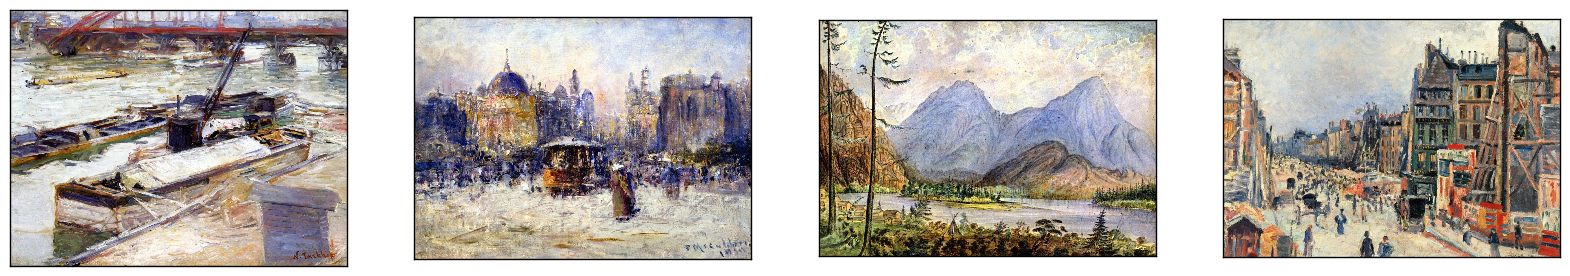

In [24]:
%%time
plot_columns(get_paintings_around_centroid_precalculated(0, color_hist, 4))

CPU times: user 418 ms, sys: 19.5 ms, total: 438 ms
Wall time: 450 ms


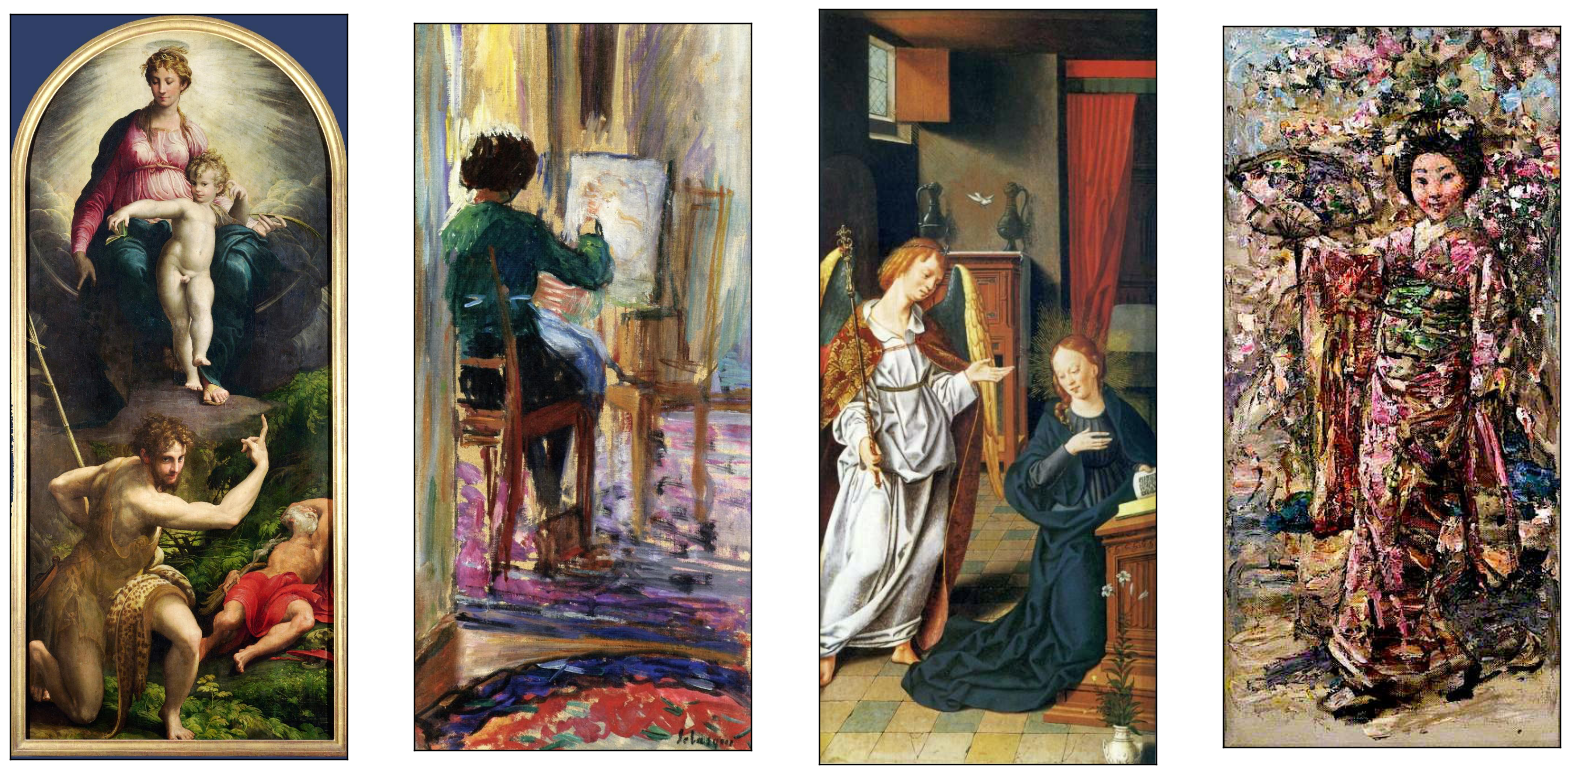

In [25]:
%%time
plot_columns(get_paintings_around_centroid_precalculated(1, color_hist, 4))

CPU times: user 444 ms, sys: 29 ms, total: 473 ms
Wall time: 483 ms


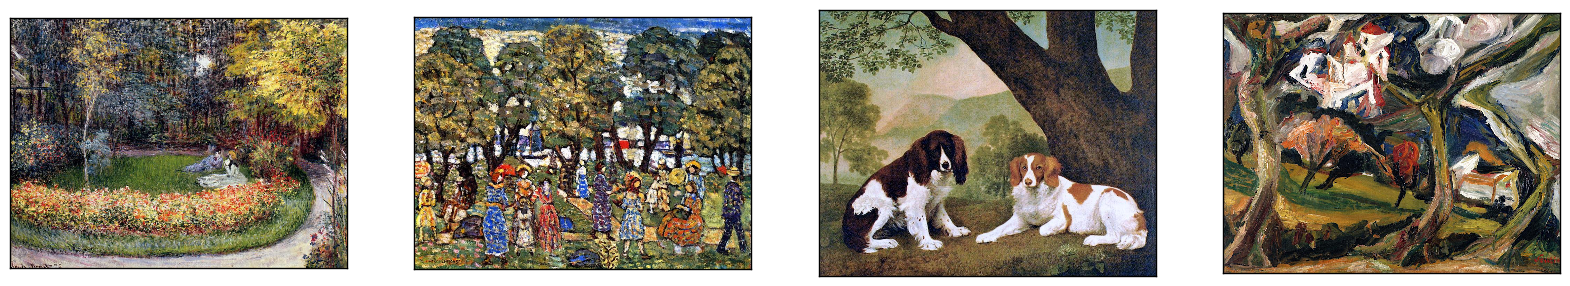

In [29]:
%%time
plot_columns(get_paintings_around_centroid_precalculated(2, color_hist, 4))

CPU times: user 1.78 s, sys: 69.8 ms, total: 1.85 s
Wall time: 1.91 s


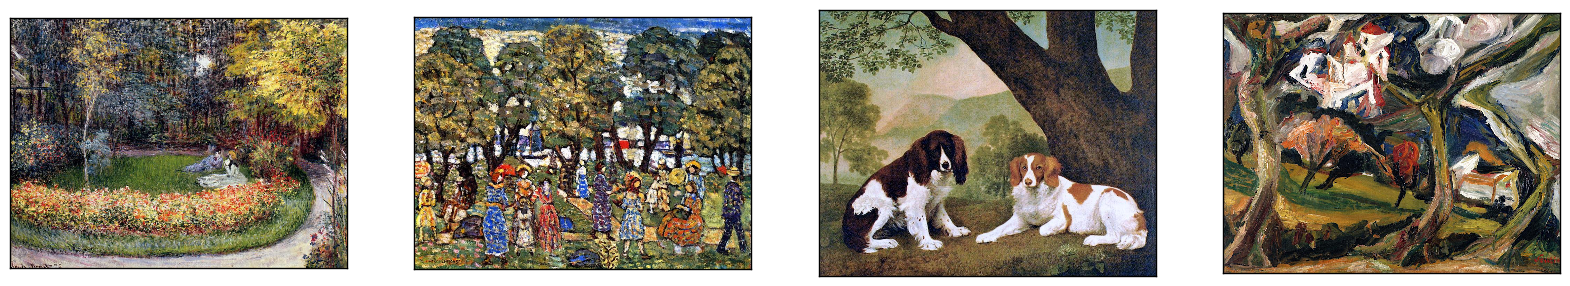

In [28]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[2], color_hist, 4))

CPU times: user 1.78 s, sys: 79.7 ms, total: 1.86 s
Wall time: 1.91 s


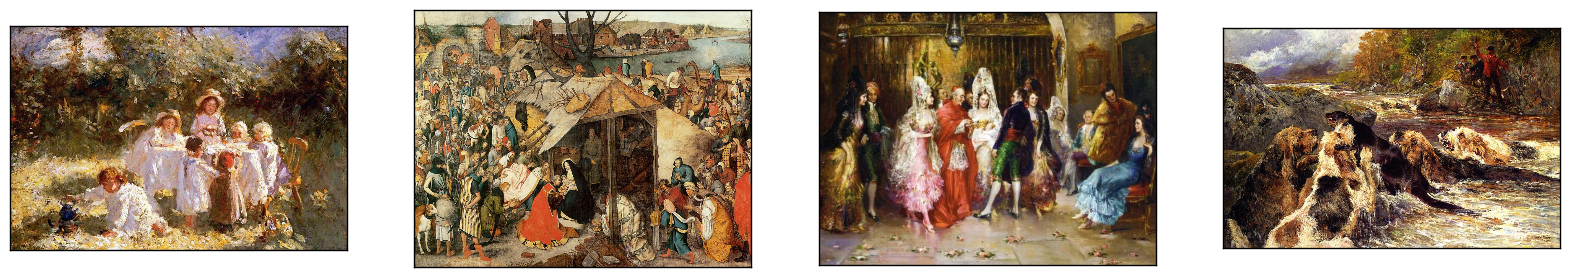

In [18]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[3], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[4], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[5], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[6], color_hist, 4))

In [ ]:
def plot_columns_kmeans(centroids, color_hist, num_per_cluster, art_movements = None):
    base_dim = 18
    from PIL import Image
    f, ax = plt.subplots(centroids.shape[0], num_per_cluster,
                         figsize = (base_dim, base_dim * centroids.shape[0] / num_per_cluster))
    for y, centroid in enumerate(centroids):
        paintings = get_paintings_around_centroid(centroid, color_hist, num_per_cluster)
        if art_movements is not None:
            paintings = paintings.merge(art_movements[['author_id', 'painting_id', 'sup_art_movement']], how = 'left',
                                        on = ['author_id', 'painting_id'])
        for i in range(len(paintings)):
            im = Image.open('data/images_athenaeum/full/%d/%d.jpg' % (paintings.iloc[i]['author_id'],
                                                                  paintings.iloc[i]['painting_id']))
            curAxis = ax[y, i] if num_per_cluster > 1 else ax[y]
            curAxis.imshow(im)
            curAxis.set_yticks([])
            curAxis.set_xticks([])
            if art_movements is not None:
                curAxis.set_title(paintings.iloc[i]['sup_art_movement'])
            if i == 0:
                curAxis.set_ylabel('cluster #%d' % y)

In [ ]:
color_hist.head(1)

In [ ]:
%%time
plot_columns_kmeans(kmeans.cluster_centers_, color_hist, 8, art_movements=pd.read_csv('data/athenaeum_painting_movement.csv'))

In [ ]:
# calculate the distance
kmeans_centers = pd.read_csv('data/kmeans_centers.csv')
kmeans_centers.head(1)

In [ ]:
color_hist[color_hist['kmeans_labels'] == 0].iloc[:, 2:-1].shape

# TSNE for cluster plotting

In [ ]:
# Memory error
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne.fit_transform(color_hist.iloc[:, 1:]) 

In [ ]:
tsne_data = pd.concat([train_tsne.reset_index(drop=True), test_tsne], axis=0)
print tsne_data.shape
tsne_data.head(1)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne_trainsformed = tsne.fit_transform(tsne_data.iloc[:, 2:-1].sample(5000,random_state = 123)) 

In [ ]:
tsne_data.head(1)

In [ ]:
from time import time
from sklearn.manifold import TSNE

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = TSNE(n_components=2, init='pca', random_state=2017)
trans_data = tsne.fit_transform(tsne_data.iloc[:, 2:-1].sample(5000)).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = plt.figure(figsize=(15, 8))


In [ ]:
tsne_trainsformed

In [ ]:
colors = tsne_data.iloc[:, -1].sample(5000,random_state = 123)
fig = plt.figure(figsize=(18, 10))

plt.scatter(tsne_trainsformed[:,0], tsne_trainsformed[:,1],
            c=np.array(colors), 
            cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis('normal')
plt.show()
fig.savefig('data/kmeans_tsne.png', dpi=fig.dpi)


In [ ]:
tsne_data.head(2)

In [ ]:
np.array(colors)

In [ ]:
from time import time
t0 = time()
## Get 2 principal components

subset = np.random.choice(range(tsne_data.shape[0]), size = 5000)
pca = PCA(n_components=2, random_state=2017)
pca.fit(tsne_data.iloc[:,2:-1])
pca_transformed = pca.transform(tsne_data.iloc[:, 2:-1])#[subset]

t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = plt.figure(figsize=(15, 8))
colors = tsne_data.iloc[:, -1]
fig = plt.figure(figsize=(18, 10))
plt.scatter(pca_transformed[:,0], pca_transformed[:,1]
            ,
            c=np.array(colors), 
            cmap=plt.cm.rainbow,
            alpha = 0.5, lw = 0, s = 6
           )
plt.title("PCA (%.2g sec)" % (t1 - t0))
plt.axis('normal')
plt.show()

# fig.savefig('data/kmeans.png', dpi=fig.dpi)


In [ ]:
cluster_data = tsne_data.sample(5000,random_state = 123)
cluster_data.groupby(['painting_id', 'kmeans_labels']).agg('sum').head(3)

In [ ]:
cluster_data[cluster_data['author_id'] == 24]['kmeans_labels'].value_counts()

In [ ]:
authors = pd.read_csv('data/athenaeum_authors.csv')
sum(authors.first_name == 'Vincent')

In [ ]:
authors[authors.last_name == 'Gogh']

In [ ]:
authors[authors.last_name == 'Monet']

## Van Gogh Analysis

In [ ]:
van_gogh_data = cluster_data[cluster_data['author_id'] == 789][['author_id', 'painting_id' ,'kmeans_labels']]
van_gogh_data.head(5)

In [ ]:
van_gogh_data.iloc[:, 1:].groupby(['kmeans_labels']).agg('count').reset_index().rename(columns={'painting_id':'painting_num'})

In [ ]:
van_gogh_clusters = {}
for i in range(7):
    name = 'van_gogh_%d' % i
    van_gogh_clusters[name] = van_gogh_data[van_gogh_data['kmeans_labels'] == i]
    
# van_gogh_clusters

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_0'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_1'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_2'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_3'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_4'])

In [ ]:
# No cluster 5 for van gogh
plot_columns(van_gogh_clusters['van_gogh_5'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_6'])

In [ ]:
van_gogh_6 = van_gogh_data[van_gogh_data['kmeans_labels'] == 6]
van_gogh_6.head(3)

## Monet Analysis

In [ ]:
Monet_data = cluster_data[cluster_data['author_id'] == 13][['author_id', 'painting_id' ,'kmeans_labels']]
Monet_data.head(3)

In [ ]:
Monet_data.iloc[:, 1:].groupby(['kmeans_labels']).agg('count').reset_index().rename(columns={'painting_id':'painting_num'})

In [ ]:
monet_clusters = {}
for i in range(7):
    name = 'monet_%d' % i
    monet_clusters[name] = Monet_data[Monet_data['kmeans_labels'] == i]
    
# monet_clusters    

In [ ]:
plot_columns(monet_clusters['monet_0'])

In [ ]:
plot_columns(monet_clusters['monet_1'])

In [ ]:
plot_columns(monet_clusters['monet_2'])

In [ ]:
plot_columns(monet_clusters['monet_3'])

In [ ]:
plot_columns(monet_clusters['monet_4'])

In [ ]:
plot_columns(monet_clusters['monet_5'])

In [ ]:
plot_columns(monet_clusters['monet_6'])

# clusters for paintings

In [ ]:
cluster_data.head(2)

In [ ]:
cluster_data[['painting_id', 'kmeans_labels']].groupby('kmeans_labels').agg('count').rename(columns={'painting_id': 'painting_num'})

In [ ]:
cluster_data[cluster_data['kmeans_labels'] == 0].head(3)

In [ ]:
paintings_clusters = {}
for i in range(7):
    name = 'cluster_%d' % i
    paintings_clusters[name] = cluster_data[cluster_data['kmeans_labels'] == i]
    
# paintings_clusters  

In [ ]:
plot_columns(paintings_clusters['cluster_0'])

In [ ]:
plot_columns(paintings_clusters['cluster_1'])

In [ ]:
plot_columns(paintings_clusters['cluster_2'])

In [ ]:
plot_columns(paintings_clusters['cluster_3'])

In [ ]:
plot_columns(paintings_clusters['cluster_4'])

In [ ]:
plot_columns(paintings_clusters['cluster_5'])

In [ ]:
plot_columns(paintings_clusters['cluster_6'])

In [ ]:
def get_paintings_around_centroid(centroid, color_hist, num_paintings):
    distances = color_hist.iloc[:, 2:-1].apply(lambda row: sum((row - centroid) ** 2), raw = True, axis = 1)
    return color_hist.loc[distances.sort_values()[:num_paintings].index, ['painting_id', 'author_id']]

In [ ]:
color_hist.loc[:,'painting_id']
distances.nsmallest(4).index